In [28]:
sd = 123 # Here sd means seed.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date
import scripts.LstmStrategy as sl
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import importlib
import scripts.Strategy as ss
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import LSTM,RepeatVector,TimeDistributed,Dense,Dropout
from keras.callbacks import EarlyStopping
%load_ext autoreload
%autoreload 2
#importlib.reload(ss) #above magic works so won't need to manual reload
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (17, 6)
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
import numpy as np
import random as rn


np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)

from keras import backend as K
tf.random.set_seed(sd)
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#data prepare
start=date(1990, 1, 1)
end=date(2020, 11, 16)

#stock_list=['ICE', 'WLTW']
stock_list=['BABA', 'BBY']
stock_pair=yf.download(stock_list, start, end, progress = False)

stock_pair=stock_pair[['Adj Close']].copy()
stock_pair.dropna(how='any', axis=0, inplace=True)
stock_pair.columns=stock_pair.columns.droplevel()
stock_pair.index=pd.DatetimeIndex(stock_pair.index)
#stock_pair.head()
dog_leash=stock_pair.copy()
smoothing='yes'
if smoothing=='yes':
        dog_leash=dog_leash.rolling(window=5).mean()
        dog_leash.dropna(inplace=True)
c=np.polyfit(dog_leash.iloc[:, 0], dog_leash.iloc[:, 1], 1)
dog_leash['Dog_leash']=dog_leash.iloc[:, 1]-c[0]*dog_leash.iloc[:, 0]
dog_leash=dog_leash[['Dog_leash']]
test_data=pd.merge(stock_pair, dog_leash, how='outer', on='Date')
test_data.dropna(how='any', axis=0, inplace=True)
test_data=test_data.reset_index()
test_data['realcombo']=-test_data.iloc[:,1]*c[0]+test_data.iloc[:,2]
test_data['realcombo_before_std']=test_data.realcombo
#standard
test_data['realcombo']=(test_data.realcombo-test_data.realcombo.mean())/test_data.realcombo.std()

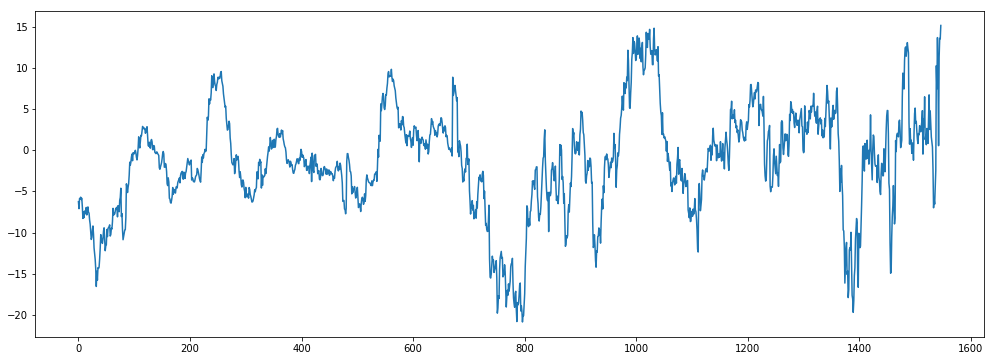

In [17]:
plt.plot(test_data.realcombo_before_std)
#plt.plot(test_data.Dog_leash)
plt.show()

In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1547 non-null   datetime64[ns]
 1   BABA                  1547 non-null   float64       
 2   BBY                   1547 non-null   float64       
 3   Dog_leash             1547 non-null   float64       
 4   realcombo             1547 non-null   float64       
 5   realcombo_before_std  1547 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 72.6 KB


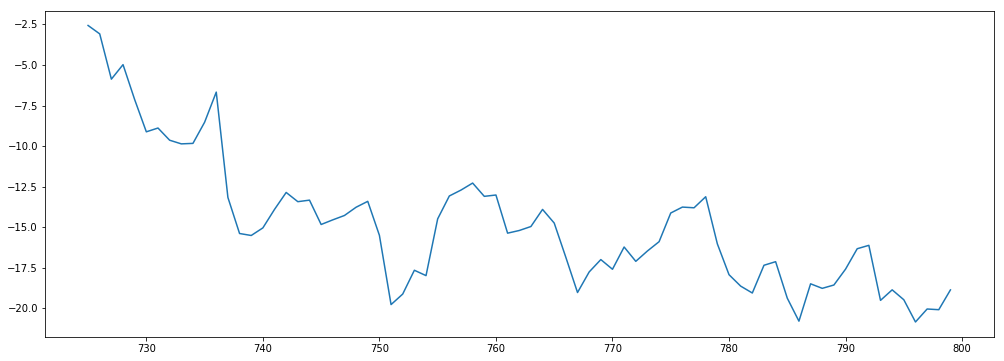

In [35]:
plt.plot(test_data.realcombo_before_std[725:800])

(300, 1)


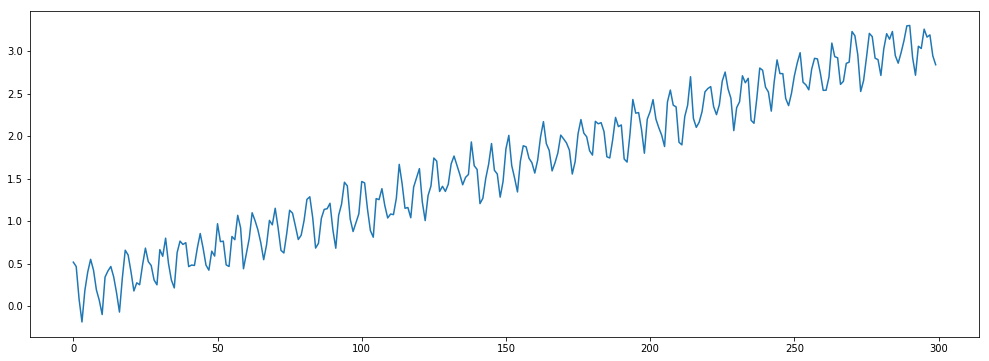

In [142]:
import random
fake_data=[]
for i in range(0,300):
    fake_data.append(i/100 +np.cos(i)/4+random.random()/3)
plt.plot(fake_data)
fake_data=fake_data-np.mean(fake_data)
fake_data_df=pd.DataFrame({'realcombo':fake_data})
print(fake_data_df.shape)

(200, 1, 1)
train size LSTM (191, 1, 7)
test size LSTM (2, 1, 7)
Epoch 1/100
191/191 [==============================] - 1s 4ms/step - loss: 0.2098 - mean_squared_error: 0.2098 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 2/100
191/191 [==============================] - 1s 3ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 3/100
191/191 [==============================] - 0s 2ms/step - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 4/100
191/191 [==============================] - 0s 3ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 5/100
191/191 [==============================] - 0s 2ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0578 - val_mean_squared_error: 0.0578
Epoch 00005: early stopping
score on test data is: 19.33%
score on all train data is: 112.97%


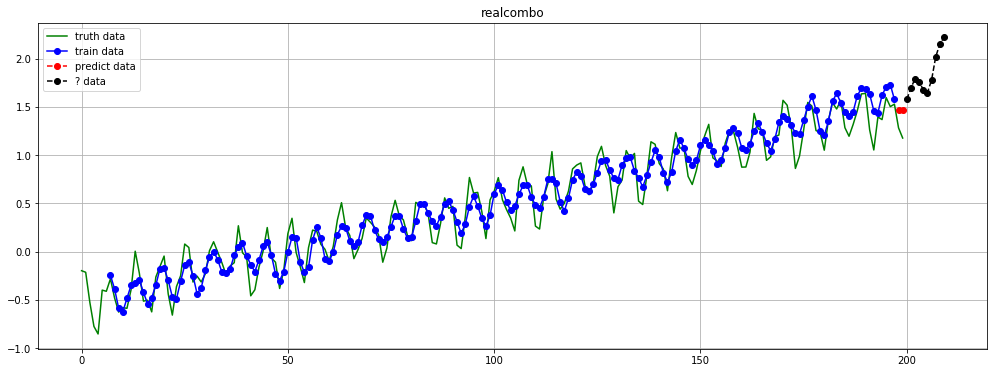

In [143]:
future=sl.model_selection(fake_data_df,100,300,7,0.01,123)

Epoch 00030: early stopping
score on all train data is: 90.98%


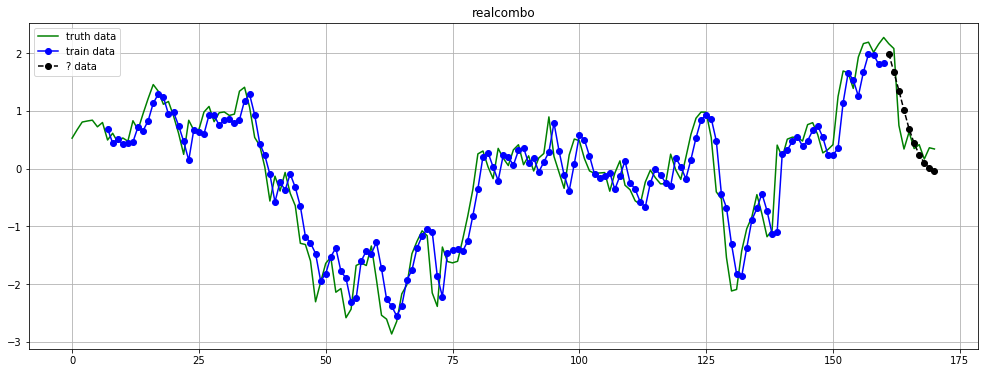

DOWN


In [201]:
DaysInYear=160
starting_point=1486-DaysInYear
future=sl.build_model_and_predict_and_show(test_data,starting_point,starting_point+DaysInYear,7,10,seed=123)
print(sl.trendHelper(future))

 start 13.0524, short ends5.1125
diff -7.9399018596576525


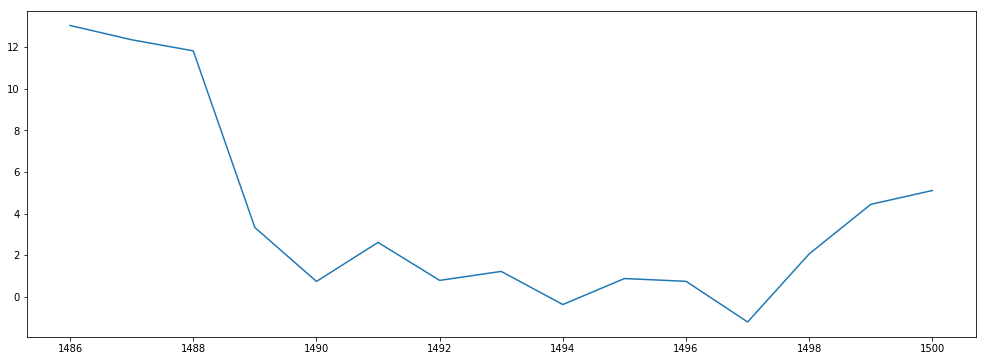

In [191]:
select_col='realcombo_before_std'
start=1486
end=1500
print(f' start {test_data.loc[start,select_col]:0.4f}, short ends{test_data.loc[end,select_col]:0.4f}')
print(f'diff {test_data.loc[end,select_col]-test_data.loc[start,select_col]}')
plt.plot(test_data.realcombo_before_std[start:end+1])

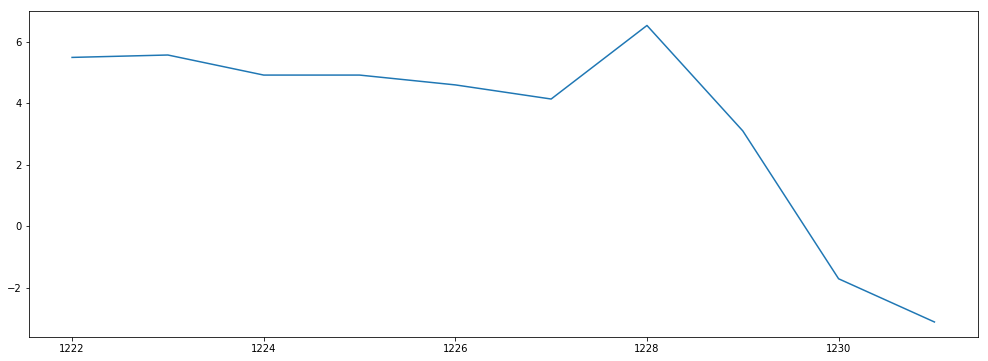

In [107]:
profit=0

traiding_start=-len(test_data)
ending=len(test_data)
#test_start=-100
main_list=[]
temp_list=[]
current_position='-'
openOptionTrend=''
    
for i in range(110,ending):
    start_point=i
    real,prediction=ss.getPredictionAndRealData(results,test_data,start_point)
    #current_trend=trendHelper(real)
    #t,next_trend=trendPredictor(current_trend,[],prediction)
    action, buyOrShort=ss.positionStrategy(current_position,openOptionTrend,real,prediction)
    #print(f'idx {i} position strategy:  {action} {buyOrShort} current position {current_position}')
    #print(f'current index {start_point}, current_trend {current_trend},next_trend is {next_trend},current position {current_position} action:{action}')
    
    if(action=='C'):
        #FIRST NEED TO LOSE AND THEN ENTER NEW POSITION
        lastest_position=main_list[-1]
        prev_price=lastest_position[3]
        prev_strategy=lastest_position[-1]
        if(prev_strategy=='L'):
            position0=test_data.iloc[start_point, 2]-c[0]*test_data.iloc[start_point, 1]
            profit=profit+(position0-prev_price)
        if(prev_strategy=='S'):
            position0=c[0]*test_data.iloc[start_point, 1]-test_data.iloc[start_point, 2]
            profit=profit+(position0-prev_price)
        print(f'idx {lastest_position[0]} to idx {start_point}. prev_price {prev_price}, curr price {position0} profit is {position0-prev_price} stragegy:{prev_strategy}')
    if(buyOrShort=='L'):
            position0=test_data.iloc[start_point, 2]-c[0]*test_data.iloc[start_point, 1]
            temp_list=[start_point, -test_data.iloc[start_point, 1], test_data.iloc[start_point, 2], position0, c[0], 'O',buyOrShort]
            main_list.append(temp_list)
            openOptionTrend='UP'
            current_position='O'
    if(buyOrShort=='S'):
            position0=c[0]*test_data.iloc[start_point, 1]-test_data.iloc[start_point, 2]
            temp_list=[start_point, test_data.iloc[start_point, 1], -test_data.iloc[start_point, 2], position0, c[0], 'O',buyOrShort]
            main_list.append(temp_list)
            openOptionTrend='DOWN'
            current_position='O'
 
            
          
    

idx 175 to idx 284. prev_price -49.361257810226356, curr price -32.22211752064294 profit is 17.139140289583416 stragegy:S
idx 284 to idx 290. prev_price 32.22211752064294, curr price 39.418237960822744 profit is 7.196120440179804 stragegy:L
idx 290 to idx 518. prev_price -39.418237960822744, curr price -15.66473699639343 profit is 23.753500964429314 stragegy:S
idx 518 to idx 524. prev_price 15.66473699639343, curr price 16.432271167495095 profit is 0.7675341711016657 stragegy:L
idx 524 to idx 525. prev_price -16.432271167495095, curr price -15.05381805322395 profit is 1.3784531142711458 stragegy:S
idx 525 to idx 531. prev_price 15.05381805322395, curr price 18.624351818352615 profit is 3.5705337651286655 stragegy:L
idx 531 to idx 536. prev_price -18.624351818352615, curr price -20.001920740447716 profit is -1.3775689220951008 stragegy:S
idx 536 to idx 539. prev_price 20.001920740447716, curr price 25.702484633605486 profit is 5.700563893157771 stragegy:L
idx 539 to idx 812. prev_price 

In [108]:
profit

31.20245958481547

In [76]:
test_results=pd.DataFrame(main_list, columns=('day_index', 'low_pos', 'high_pos', 'p_l', 'coef', 'Trade_type','L/S'))
test_results.to_csv('./data/mymainlistreulst.csv')